### This notebook is used for training/testing and Model Building

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
import boto3
import io
s3 = boto3.client('s3')

In [37]:
obj = s3.get_object(Bucket='team036vsix', Key='df_final_0328.csv')
df_full = pd.read_csv(io.BytesIO(obj['Body'].read()))

In [38]:
df_full.head()

,Unnamed: 0,State,County,Date,Temperature,Covid_Count,Acc_Count,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy
0,0,AL,Autauga,2020-01-02,50.000000,0,1,0,0,0,1,0,0,0
1,1,AL,Autauga,2020-01-03,63.333333,0,3,0,0,0,1,0,0,0
2,2,AL,Autauga,2020-01-04,43.000000,0,1,0,1,0,0,0,0,0
3,3,AL,Autauga,2020-01-07,53.000000,0,1,0,1,0,0,0,0,0
4,4,AL,Autauga,2020-01-08,41.000000,0,2,0,1,0,0,0,0,0


In [5]:
df_full['Acc_date']= pd.to_datetime(df_full['Acc_date'])


In [6]:
obj = s3.get_object(Bucket='team036vsix', Key='weather_cond.csv')
df_w = pd.read_csv(io.BytesIO(obj['Body'].read()))

In [7]:
df_w.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9'], axis=1, inplace=True)


In [9]:
df_w.columns = ['Weather_Condition', 'New_name']
df_w.head()

,Weather_Condition,New_name
0,Rain,Rain
1,T-Storm,Storm
2,Heavy Rain / Windy,Rain
3,Light Rain with Thunder,Rain
4,Light Snow,Snow


In [10]:
df_new=pd.merge(df_full, df_w, on='Weather_Condition', how='inner')

In [11]:
df_new.drop(['Weather_Condition'], axis=1, inplace=True)
df_new.rename(columns = {'New_name':'Weather_Condition'}, inplace = True)

In [12]:
df_new.head()

,Severity,Start_Lat,Start_Lng,County,State,Temperature(F),Bump,Junction,Crossing,Stop,Traffic_Signal,Acc_date,Region,Weather_Condition
0,3,35.126778,-89.868248,Shelby,TN,18.0,0,0,0,0,0,2017-12-28 00:00:00+00:00,South,Cloudy
1,3,35.152302,-89.883469,Shelby,TN,21.2,0,1,0,0,0,2017-12-28 00:00:00+00:00,South,Cloudy
2,3,35.152302,-89.883469,Shelby,TN,24.8,0,1,0,0,0,2017-12-28 00:00:00+00:00,South,Cloudy
3,2,35.204502,-89.760605,Shelby,TN,28.4,0,0,0,0,1,2017-12-28 00:00:00+00:00,South,Cloudy
4,2,36.045734,-86.674355,Davidson,TN,15.1,0,0,0,0,0,2017-12-28 00:00:00+00:00,South,Cloudy


In [13]:
df_1= df_new.groupby(['State','County','Acc_date'])['Temperature(F)'].mean()
#df.groupby('param')['group'].nunique())
df_1.columns=['State','County','Date','Temp']
df_1.head()

State  County   Acc_date                 
AL     Autauga  2016-08-18 00:00:00+00:00    93.7
                2017-05-23 00:00:00+00:00    68.0
                2017-07-27 00:00:00+00:00    77.0
                2017-08-21 00:00:00+00:00    89.8
                2017-12-08 00:00:00+00:00    35.6
Name: Temperature(F), dtype: float64

In [14]:
df_new1=pd.merge(df_new, df_1, on=['State','County','Acc_date'], how='inner')

In [15]:
df_new1.drop(['Temperature(F)_x'], axis=1, inplace=True)
df_new1.rename(columns = {'Temperature(F)_y':'Temperature'}, inplace = True)

In [16]:
df_wea= df_new1.groupby(['State','County','Acc_date'])['Weather_Condition'].agg(
    lambda x: pd.Series.mode(x)[0])

In [17]:
df_new2=pd.merge(df_new1, df_wea, on=['State','County','Acc_date'], how='inner')

In [18]:
df_new2.drop(['Weather_Condition_x'], axis=1, inplace=True)
df_new2.rename(columns = {'Weather_Condition_y':'Weather_Condition'}, inplace = True)
df_new2.head()

,Severity,Start_Lat,Start_Lng,County,State,Bump,Junction,Crossing,Stop,Traffic_Signal,Acc_date,Region,Temperature,Weather_Condition
0,3,35.126778,-89.868248,Shelby,TN,0,0,0,0,0,2017-12-28 00:00:00+00:00,South,23.100000,Cloudy
1,3,35.152302,-89.883469,Shelby,TN,0,1,0,0,0,2017-12-28 00:00:00+00:00,South,23.100000,Cloudy
2,3,35.152302,-89.883469,Shelby,TN,0,1,0,0,0,2017-12-28 00:00:00+00:00,South,23.100000,Cloudy
3,2,35.204502,-89.760605,Shelby,TN,0,0,0,0,1,2017-12-28 00:00:00+00:00,South,23.100000,Cloudy
4,2,36.045734,-86.674355,Davidson,TN,0,0,0,0,0,2017-12-28 00:00:00+00:00,South,25.166667,Cloudy


In [19]:
df_count=df_new2.groupby(['State','County','Acc_date','Weather_Condition','Temperature']).size().reset_index(name='Count')

In [85]:
df_count.count()

State                459876
County               459876
Acc_date             459876
Weather_Condition    459876
Temperature          459876
Count                459876
dtype: int64

In [22]:
df_count['Acc_date'] = df_count['Acc_date'].dt.date

In [24]:
df_dum=pd.get_dummies(df_count, prefix=['Weather_Condition'], columns=['Weather_Condition'])

In [27]:
df_dum['Acc_date']= pd.to_datetime(df_dum['Acc_date'])


In [88]:
df_dum.head()

,State,County,Acc_date,Temperature,Count,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy
0,AL,Autauga,2016-08-18,93.7,1,1,0,0,0,0,0,0
1,AL,Autauga,2017-05-23,68.0,1,0,0,0,1,0,0,0
2,AL,Autauga,2017-07-27,77.0,1,0,0,0,1,0,0,0
3,AL,Autauga,2017-08-21,89.8,1,1,0,0,0,0,0,0
4,AL,Autauga,2017-12-08,35.6,1,0,0,0,1,0,0,0


#### The following code is used to create Linear Regression model for  Prediction of accident counts(2020) using entire dataset(2016-2019) as Training set

In [32]:
df_2019=df_dum[df_dum['Acc_date']<='2019-12-31']
df_2019.head()

,State,County,Acc_date,Temperature,Count,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy
0,AL,Autauga,2016-08-18,93.7,1,1,0,0,0,0,0,0
1,AL,Autauga,2017-05-23,68.0,1,0,0,0,1,0,0,0
2,AL,Autauga,2017-07-27,77.0,1,0,0,0,1,0,0,0
3,AL,Autauga,2017-08-21,89.8,1,1,0,0,0,0,0,0
4,AL,Autauga,2017-12-08,35.6,1,0,0,0,1,0,0,0


In [40]:
df_2020=df_dum[df_dum['Acc_date']>='2020-01-01']


In [33]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [37]:
x_train=df_2019[['Temperature','Weather_Condition_Cloudy','Weather_Condition_Fair','Weather_Condition_Fog','Weather_Condition_Rain','Weather_Condition_Snow','Weather_Condition_Storm','Weather_Condition_Windy']]
y_train=df_2019[['Count']]

In [41]:
x_test=df_2020[['Temperature','Weather_Condition_Cloudy','Weather_Condition_Fair','Weather_Condition_Fog','Weather_Condition_Rain','Weather_Condition_Snow','Weather_Condition_Storm','Weather_Condition_Windy']]
y_test=df_2020[['Count']]


In [42]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(304455, 8) (304455, 1) (155421, 8) (155421, 1)


In [39]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [43]:
predictions = model.predict(x_test)


In [44]:
r2_score = model.score(x_test,y_test)
print(r2_score*100,'%')

-1.6830727177030047 %


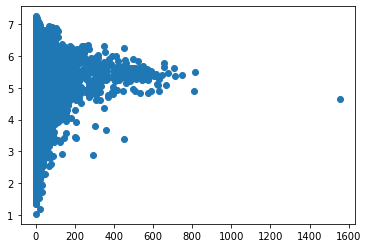

In [45]:
plt.scatter(y_test,predictions)

In [47]:
#print(y_test)
print(type(predictions))

<class 'numpy.ndarray'>


In [54]:
pred_list=predictions.tolist()
flat_list = [item for sublist in pred_list for item in sublist]
flat_list

[4.728345979386312,
 5.201291949921586,
 4.847594199357789,
 5.202303677259245,
 4.776652303777498,
 5.398328814364799,
 5.132296705938707,
 5.32248435487125,
 5.185503127623925,
 5.203238601518999,
 4.847594199357789,
 4.3381655536947115,
 5.220039151154317,
 4.742116280247107,
 4.635703436876669,
 5.23777462504939,
 4.741181355987353,
 5.079090284253489,
 4.930359744201462,
 5.203238601518999,
 4.600232489086524,
 4.98947799051837,
 4.884000071407689,
 4.799287874966604,
 4.98947799051837,
 5.095890833888808,
 4.887965244441967,
 4.6702394604070605,
 5.274180497099289,
 5.0475845094976215,
 4.919471019197834,
 5.344187468419827,
 5.4151293640001175,
 5.274180497099289,
 5.8053097896917185,
 6.124548319803029,
 5.096825758148562,
 6.230961163173465,
 5.451535236050017,
 4.919471019197834,
 5.699831870581036,
 5.557948079420454,
 5.698896946321282,
 6.301903058753757,
 5.0604198860986624,
 5.0613548103584165,
 5.521542207370555,
 5.87625168527201,
 5.185503127623925,
 5.663425998531137

In [55]:
df_2020['Predict_Count']=flat_list

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [64]:
df_2020.dtypes

State                               object
County                              object
Acc_date                    datetime64[ns]
Temperature                        float64
Count                                int64
Weather_Condition_Cloudy             uint8
Weather_Condition_Fair               uint8
Weather_Condition_Fog                uint8
Weather_Condition_Rain               uint8
Weather_Condition_Snow               uint8
Weather_Condition_Storm              uint8
Weather_Condition_Windy              uint8
Predict_Count                        int64
dtype: object

In [62]:
df_2020['Predict_Count'] = df_2020['Predict_Count'].astype(int)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [65]:
df_2020['Acc_Month']=df_2020['Acc_date'].dt.month

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [66]:
df_2020.head()

,State,County,Acc_date,Temperature,Count,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy,Predict_Count,Acc_Month
144,AL,Autauga,2020-01-02,50.000000,1,0,0,0,1,0,0,0,4,1
145,AL,Autauga,2020-01-03,63.333333,3,0,0,0,1,0,0,0,5,1
146,AL,Autauga,2020-01-04,43.000000,1,0,1,0,0,0,0,0,4,1
147,AL,Autauga,2020-01-07,53.000000,1,0,1,0,0,0,0,0,5,1
148,AL,Autauga,2020-01-08,41.000000,2,0,1,0,0,0,0,0,4,1


In [67]:
df_gr= df_2020.groupby(['State','County','Acc_Month']).agg({'Count':'sum','Predict_Count':'sum'}).reset_index()
#df.groupby(['col1','col2']).agg({'col3':'sum','col4':'sum'}).reset_index()
df_gr.head()

,State,County,Acc_Month,Count,Predict_Count
0,AL,Autauga,1,26,73
1,AL,Autauga,2,23,51
2,AL,Autauga,3,19,70
3,AL,Autauga,4,18,52
4,AL,Autauga,5,23,48


In [71]:
df_gr['Accuracy']=((df_gr['Predict_Count']-df_gr['Count'])/df_gr['Predict_Count'])*100

In [78]:
df_gr.head()

,State,County,Acc_Month,Count,Predict_Count
0,AL,Autauga,1,26,73
1,AL,Autauga,2,23,51
2,AL,Autauga,3,19,70
3,AL,Autauga,4,18,52
4,AL,Autauga,5,23,48


In [80]:
from io import StringIO # python3; python2: BytesIO 
import boto3

bucket = 'team036vsix' # already created on S3
csv_buffer = StringIO()
df_gr.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'reg_out_2020_0416.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'HJWN13RVM0XMVY4P',
  'HostId': 'w1dsVjX5fhPLW4sd1QFNCyD3NRcMJrqmjxUKCu12Wh1gWhmGfdN/6AdzgegWiivduZ0ynAZiO6w=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'w1dsVjX5fhPLW4sd1QFNCyD3NRcMJrqmjxUKCu12Wh1gWhmGfdN/6AdzgegWiivduZ0ynAZiO6w=',
   'x-amz-request-id': 'HJWN13RVM0XMVY4P',
   'date': 'Sat, 17 Apr 2021 01:38:39 GMT',
   'etag': '"3fd3f91a73215df1ef34e008613ae381"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"3fd3f91a73215df1ef34e008613ae381"'}

In [84]:


bucket = 'team036vsix' # already created on S3
csv_buffer = StringIO()
df_dum.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'full_modelready_0416.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'MP3QET867Q7XJKW1',
  'HostId': 'rdpWIRBW5o1rAIIqZO/NYDEyqrRgyYm1AMOxooy4tq0jmi6QSvgrFWU9XGyiMmlqltZZUalinX8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'rdpWIRBW5o1rAIIqZO/NYDEyqrRgyYm1AMOxooy4tq0jmi6QSvgrFWU9XGyiMmlqltZZUalinX8=',
   'x-amz-request-id': 'MP3QET867Q7XJKW1',
   'date': 'Sat, 17 Apr 2021 01:41:34 GMT',
   'etag': '"eeb076d68b4cbb35597af0a84a86443f"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"eeb076d68b4cbb35597af0a84a86443f"'}

In [3]:
obj = s3.get_object(Bucket='team036vsix', Key='full_modelready_0416.csv')
df_full = pd.read_csv(io.BytesIO(obj['Body'].read()))

In [41]:
df_full.head()

,State,County,Date,Temperature,Covid_Count,Acc_Count,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy
0,AL,Autauga,2020-01-02,50.000000,0,1,0,0,0,1,0,0,0
1,AL,Autauga,2020-01-03,63.333333,0,3,0,0,0,1,0,0,0
2,AL,Autauga,2020-01-04,43.000000,0,1,0,1,0,0,0,0,0
3,AL,Autauga,2020-01-07,53.000000,0,1,0,1,0,0,0,0,0
4,AL,Autauga,2020-01-08,41.000000,0,2,0,1,0,0,0,0,0


In [40]:
df_full.drop(['Unnamed: 0'], axis=1, inplace=True)


In [8]:
df_2020=df_full[df_full['Acc_date']>='2020-01-01']
df_2020.head()

,State,County,Acc_date,Temperature,Count,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy
144,AL,Autauga,2020-01-02,50.000000,1,0,0,0,1,0,0,0
145,AL,Autauga,2020-01-03,63.333333,3,0,0,0,1,0,0,0
146,AL,Autauga,2020-01-04,43.000000,1,0,1,0,0,0,0,0
147,AL,Autauga,2020-01-07,53.000000,1,0,1,0,0,0,0,0
148,AL,Autauga,2020-01-08,41.000000,2,0,1,0,0,0,0,0


In [42]:
df_full.count()

State                       155421
County                      155421
Date                        155421
Temperature                 155421
Covid_Count                 155421
Acc_Count                   155421
Weather_Condition_Cloudy    155421
Weather_Condition_Fair      155421
Weather_Condition_Fog       155421
Weather_Condition_Rain      155421
Weather_Condition_Snow      155421
Weather_Condition_Storm     155421
Weather_Condition_Windy     155421
dtype: int64

#### The following code is used to create Linear Regression model for  Prediction of accident counts(2020) using 2020 dataset(training(0.7)/testing(0.3)) with/without COVID count as a feature

In [10]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [12]:
from sklearn.model_selection import train_test_split

In [43]:
df_full.head(2)

,State,County,Date,Temperature,Covid_Count,Acc_Count,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy
0,AL,Autauga,2020-01-02,50.000000,0,1,0,0,0,1,0,0,0
1,AL,Autauga,2020-01-03,63.333333,0,3,0,0,0,1,0,0,0


In [44]:
x=df_full[['State','County','Date','Covid_Count','Acc_Count','Temperature','Weather_Condition_Cloudy','Weather_Condition_Fair','Weather_Condition_Fog','Weather_Condition_Rain','Weather_Condition_Snow','Weather_Condition_Storm','Weather_Condition_Windy']]
y=df_full[['Acc_Count']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)


In [45]:
x_test.head()

,State,County,Date,Covid_Count,Acc_Count,Temperature,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy
11082,CA,Glenn,2020-10-21,649,2,78.000000,1,0,0,0,0,0,0
131499,TN,Marion,2020-10-16,654,7,53.000000,0,1,0,0,0,0,0
115829,PA,Lehigh,2020-02-17,0,6,45.666667,0,1,0,0,0,0,0
140241,UT,Utah,2020-05-24,1704,5,59.400000,1,0,0,0,0,0,0
94418,NY,Madison,2020-12-15,1621,5,27.600000,0,0,0,0,1,0,0


In [46]:
model = LinearRegression()
model.fit(x_train[['Temperature','Weather_Condition_Cloudy','Weather_Condition_Fair','Weather_Condition_Fog','Weather_Condition_Rain','Weather_Condition_Snow','Weather_Condition_Storm','Weather_Condition_Windy']], y_train)


LinearRegression()

In [47]:
predictions = model.predict(x_test[['Temperature','Weather_Condition_Cloudy','Weather_Condition_Fair','Weather_Condition_Fog','Weather_Condition_Rain','Weather_Condition_Snow','Weather_Condition_Storm','Weather_Condition_Windy']])


In [48]:
predictions.shape

(46627, 1)

In [49]:
pred_list=predictions.tolist()
flat_list = [item for sublist in pred_list for item in sublist]
flat_list

[8.803267891545133,
 8.169012769869909,
 7.902562672341525,
 8.127453553268598,
 7.025764645592813,
 8.49158871942755,
 7.696669415160503,
 9.174794966843848,
 8.683085854548064,
 8.12110594479979,
 8.721516157076197,
 8.060010457244662,
 6.986562681124342,
 8.590488378687532,
 8.36279465898146,
 8.112919911585232,
 9.166608933629291,
 8.389462815838174,
 8.568687916162482,
 9.150033583497136,
 8.621597370503054,
 7.531574244250579,
 7.365475482154964,
 8.060010457244662,
 8.500483689808334,
 8.41527725394917,
 9.658711042414957,
 8.714024332996146,
 8.948604308378796,
 7.5056213126731395,
 7.894915286334737,
 8.585263266294637,
 6.136225580882503,
 9.211129071052264,
 8.766933787336717,
 7.846469814056849,
 8.706376946989357,
 8.214766827021247,
 8.060010457244662,
 8.191643804036799,
 9.465467800511176,
 7.586075400563203,
 8.278015082495155,
 8.568687916162482,
 7.78591297370949,
 8.33614964922862,
 9.430532867986106,
 8.387017395120402,
 9.131866531392927,
 8.568687916162482,
 7.65

In [50]:
x_test['Predict_Count']=flat_list
x_test.head(3)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,State,County,Date,Covid_Count,Acc_Count,Temperature,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy,Predict_Count
11082,CA,Glenn,2020-10-21,649,2,78.000000,1,0,0,0,0,0,0,8.803268
131499,TN,Marion,2020-10-16,654,7,53.000000,0,1,0,0,0,0,0,8.169013
115829,PA,Lehigh,2020-02-17,0,6,45.666667,0,1,0,0,0,0,0,7.902563


In [51]:
#with covid as feature
model = LinearRegression()
model.fit(x_train[['Covid_Count','Temperature','Weather_Condition_Cloudy','Weather_Condition_Fair','Weather_Condition_Fog','Weather_Condition_Rain','Weather_Condition_Snow','Weather_Condition_Storm','Weather_Condition_Windy']], y_train)


LinearRegression()

In [52]:
predictions2 = model.predict(x_test[['Covid_Count','Temperature','Weather_Condition_Cloudy','Weather_Condition_Fair','Weather_Condition_Fog','Weather_Condition_Rain','Weather_Condition_Snow','Weather_Condition_Storm','Weather_Condition_Windy']])
predictions2

array([[ 4.25212121],
       [ 3.99990716],
       [ 3.54554727],
       ...,
       [ 3.65443195],
       [89.64672909],
       [ 3.66493911]])

In [53]:
pred_list2=predictions2.tolist()
flat_list2 = [item for sublist in pred_list2 for item in sublist]
flat_list2

[4.25212120712324,
 3.999907156536464,
 3.54554726658633,
 4.791892211832573,
 5.679285309836257,
 45.505856657667984,
 3.509573137965129,
 5.908829060700349,
 9.762057825278536,
 5.724726167168319,
 4.771600658244089,
 10.910431552841725,
 3.5374977292034417,
 6.643843065566534,
 3.7350821939027643,
 3.7854289047347005,
 4.683502562604858,
 14.756564458592775,
 4.386505356935958,
 4.0066947120784,
 4.4249054518126965,
 3.6271113665147006,
 3.5962195549781617,
 4.7889896371147405,
 3.794530717797556,
 6.059512723089979,
 14.689152159095155,
 15.693884046539907,
 5.480352792132001,
 3.620706146728727,
 3.696830675432026,
 20.14399699394068,
 11.271721423155117,
 6.155869763880447,
 4.832538324272133,
 3.6802599562949174,
 6.731907437218151,
 3.6000962720773018,
 12.425670816895567,
 19.164208700327396,
 6.392363411184388,
 3.634763264215163,
 3.7084217676104374,
 3.996159768747602,
 3.701480648117408,
 3.621304549212154,
 13.443328501365908,
 6.814688950630661,
 4.348346579000354,
 5.40

In [58]:
x_test['Predict_withCovid_Count']=flat_list2
x_test.head(3)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,State,County,Date,Covid_Count,Acc_Count,Temperature,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy,Predict_Count,Predict_withCovid_Count
11082,CA,Glenn,2020-10-21,649,2,78.000000,1,0,0,0,0,0,0,8,4.252121
131499,TN,Marion,2020-10-16,654,7,53.000000,0,1,0,0,0,0,0,8,3.999907
115829,PA,Lehigh,2020-02-17,0,6,45.666667,0,1,0,0,0,0,0,7,3.545547


In [55]:
x_test['Predict_Count'] = x_test['Predict_Count'].astype(int)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [61]:
x_test['Predict_withCovid_Count'] = x_test['Predict_withCovid_Count'].astype(int)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [62]:
x_test.dtypes

State                        object
County                       object
Date                         object
Covid_Count                   int64
Acc_Count                     int64
Temperature                 float64
Weather_Condition_Cloudy      int64
Weather_Condition_Fair        int64
Weather_Condition_Fog         int64
Weather_Condition_Rain        int64
Weather_Condition_Snow        int64
Weather_Condition_Storm       int64
Weather_Condition_Windy       int64
Predict_Count                 int64
Predict_withCovid_Count       int64
dtype: object

In [63]:
x_test.head(2)

,State,County,Date,Covid_Count,Acc_Count,Temperature,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Fog,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Storm,Weather_Condition_Windy,Predict_Count,Predict_withCovid_Count
11082,CA,Glenn,2020-10-21,649,2,78.0,1,0,0,0,0,0,0,8,4
131499,TN,Marion,2020-10-16,654,7,53.0,0,1,0,0,0,0,0,8,3


In [65]:
from io import StringIO # python3; python2: BytesIO 
import boto3
bucket = 'team036vsix' # already created on S3
csv_buffer = StringIO()
x_test.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'reg_out_covid_0419.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '7RC0YDT2D49F9H8D',
  'HostId': 'VCIACe0vsul/8eAYO+b/l3z9YP+be+ovHzyntTCuL0125DWr9pITpuUjUqEXt0273D7LzSR2n8Y=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'VCIACe0vsul/8eAYO+b/l3z9YP+be+ovHzyntTCuL0125DWr9pITpuUjUqEXt0273D7LzSR2n8Y=',
   'x-amz-request-id': '7RC0YDT2D49F9H8D',
   'date': 'Tue, 20 Apr 2021 03:23:43 GMT',
   'etag': '"b6438175ac16d7f0f53405dab6c766b0"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"b6438175ac16d7f0f53405dab6c766b0"'}